## Download data from kaggle and move to s3

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import img_as_ubyte
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from skimage import filters, transform

from typing import Tuple

## look at class imbalance in train/test sets

In [3]:
train_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/train_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
train_df['img_path_real'] = train_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/train/{x}')
train_df['img_path_forged'] = train_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/train/{x}')

test_df = pd.read_csv('/root/udacity-mle-capstone/project/sign_data/test_data.csv', header=0, names=['img_path_real', 'img_path_forged', 'label'])
test_df['img_path_real'] = test_df['img_path_real'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')
test_df['img_path_forged'] = test_df['img_path_forged'].apply(lambda x : f'/root/udacity-mle-capstone/project/sign_data/test/{x}')

In [13]:
train_df['img_path_real'].iloc[0]

'/root/udacity-mle-capstone/project/sign_data/train/068/09_068.png'

In [7]:
print('train set imbalance')
print(train_df['label'].value_counts())
print(train_df['label'].value_counts(normalize=True))

train set imbalance
0    12602
1    10603
Name: label, dtype: int64
0    0.543073
1    0.456927
Name: label, dtype: float64


In [9]:
print('test set imbalance')
print(test_df['label'].value_counts())
print(test_df['label'].value_counts(normalize=True))

test set imbalance
1    2975
0    2772
Name: label, dtype: int64
1    0.517661
0    0.482339
Name: label, dtype: float64


## look at pairs of real and forged images

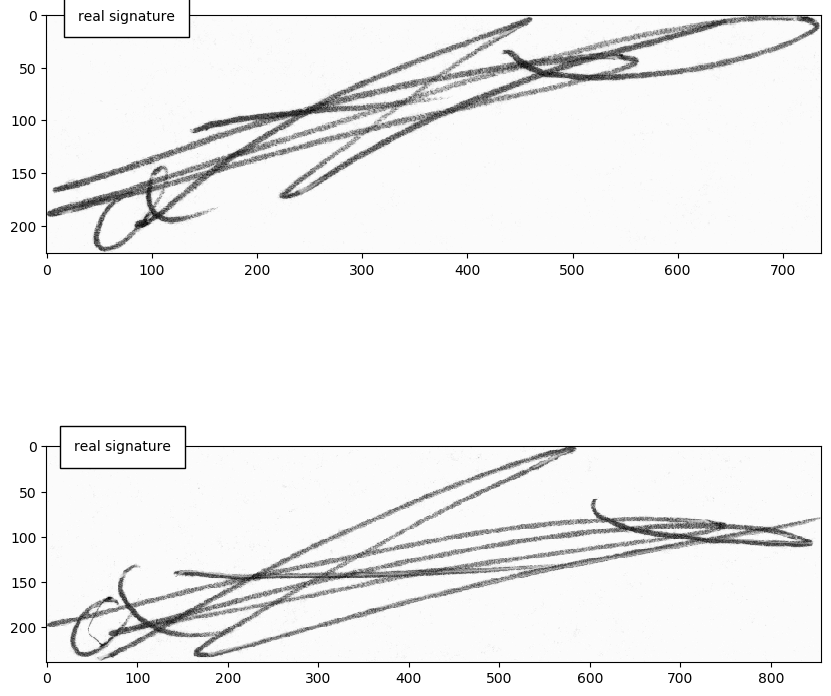

In [30]:
_df = train_df[train_df['label']==0].sample(1)
img1 = img_as_ubyte(imread(_df['img_path_real'].iloc[0], as_gray=True))
img2 = img_as_ubyte(imread(_df['img_path_forged'].iloc[0], as_gray=True))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r', label='real')
ax1.imshow(img2, cmap='binary_r')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()

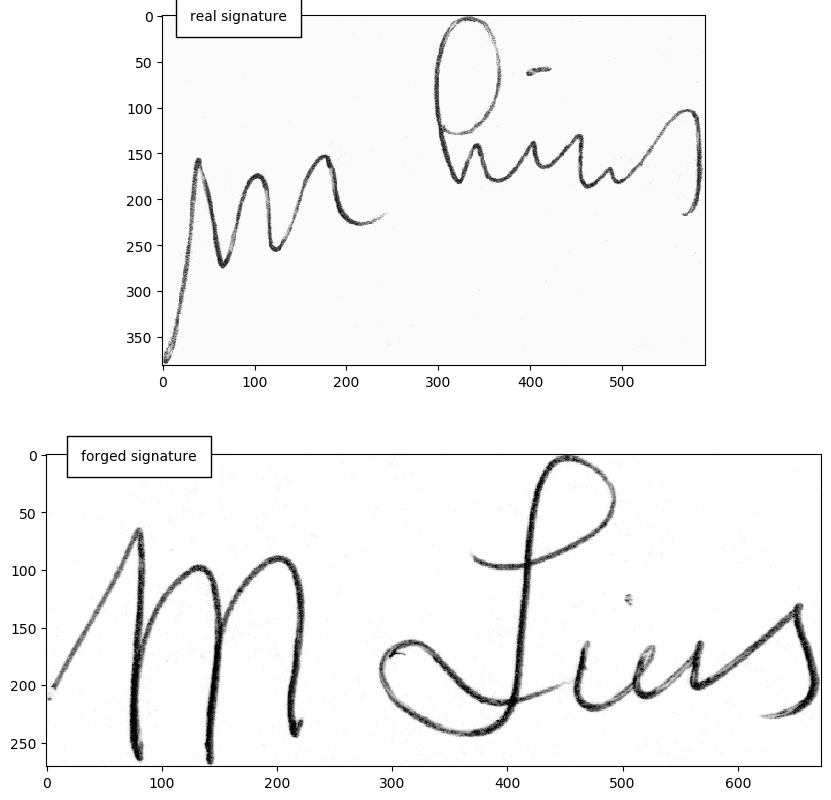

In [31]:
_df = train_df[train_df['label']==1].sample(1)
img1 = img_as_ubyte(imread(_df['img_path_real'].iloc[0], as_gray=True))
img2 = img_as_ubyte(imread(_df['img_path_forged'].iloc[0], as_gray=True))

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary_r')
ax1.imshow(img2, cmap='binary_r')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10})
plt.show()

## apply preprocessing to images

In [39]:
def preprocess_image(img: np.ndarray,
                         canvas_size: Tuple[int, int],
                         img_size: Tuple[int, int] =(170, 242),
                         input_size: Tuple[int, int] =(150, 220)) -> np.ndarray:
    img = img.astype(np.uint8)
    centered = normalize_image(img, canvas_size)
    inverted = 255 - centered
    resized = resize_image(inverted, img_size)

    if input_size is not None and input_size != img_size:
        cropped = crop_center(resized, input_size)
    else:
        cropped = resized

    return cropped

def normalize_image(img: np.ndarray,
                    canvas_size: Tuple[int, int] = (840, 1360)) -> np.ndarray:

    # 1) Crop the image before getting the center of mass

    # Apply a gaussian filter on the image to remove small components
    # Note: this is only used to define the limits to crop the image
    blur_radius = 2
    blurred_image = filters.gaussian(img, blur_radius, preserve_range=True)

    # Binarize the image using OTSU's algorithm. This is used to find the center
    # of mass of the image, and find the threshold to remove background noise
    threshold = filters.threshold_otsu(img)

    # Find the center of mass
    binarized_image = blurred_image > threshold
    r, c = np.where(binarized_image == 0)
    r_center = int(r.mean() - r.min())
    c_center = int(c.mean() - c.min())

    # Crop the image with a tight box
    cropped = img[r.min(): r.max(), c.min(): c.max()]

    # 2) Center the image
    img_rows, img_cols = cropped.shape
    max_rows, max_cols = canvas_size

    r_start = max_rows // 2 - r_center
    c_start = max_cols // 2 - c_center

    # Make sure the new image does not go off bounds
    # Emit a warning if the image needs to be cropped, since we don't want this
    # for most cases (may be ok for feature learning, so we don't raise an error)
    if img_rows > max_rows:
        # Case 1: image larger than required (height):  Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        r_start = 0
        difference = img_rows - max_rows
        crop_start = difference // 2
        cropped = cropped[crop_start:crop_start + max_rows, :]
        img_rows = max_rows
    else:
        extra_r = (r_start + img_rows) - max_rows
        # Case 2: centering exactly would require a larger image. relax the centering of the image
        if extra_r > 0:
            r_start -= extra_r
        if r_start < 0:
            r_start = 0

    if img_cols > max_cols:
        # Case 3: image larger than required (width). Crop.
        print('Warning: cropping image. The signature should be smaller than the canvas size')
        c_start = 0
        difference = img_cols - max_cols
        crop_start = difference // 2
        cropped = cropped[:, crop_start:crop_start + max_cols]
        img_cols = max_cols
    else:
        # Case 4: centering exactly would require a larger image. relax the centering of the image
        extra_c = (c_start + img_cols) - max_cols
        if extra_c > 0:
            c_start -= extra_c
        if c_start < 0:
            c_start = 0

    normalized_image = np.ones((max_rows, max_cols), dtype=np.uint8) * 255
    # Add the image to the blank canvas
    normalized_image[r_start:r_start + img_rows, c_start:c_start + img_cols] = cropped

    # Remove noise - anything higher than the threshold. Note that the image is still grayscale
    normalized_image[normalized_image > threshold] = 255

    return normalized_image


def resize_image(img: np.ndarray,
                 size: Tuple[int, int]) -> np.ndarray:
    height, width = size

    # Check which dimension needs to be cropped
    # (assuming the new height-width ratio may not match the original size)
    width_ratio = float(img.shape[1]) / width
    height_ratio = float(img.shape[0]) / height
    if width_ratio > height_ratio:
        resize_height = height
        resize_width = int(round(img.shape[1] / height_ratio))
    else:
        resize_width = width
        resize_height = int(round(img.shape[0] / width_ratio))

    # Resize the image (will still be larger than new_size in one dimension)
    img = transform.resize(img, (resize_height, resize_width),
                           mode='constant', anti_aliasing=True, preserve_range=True)

    img = img.astype(np.uint8)

    # Crop to exactly the desired new_size, using the middle of the image:
    if width_ratio > height_ratio:
        start = int(round((resize_width-width)/2.0))
        return img[:, start:start + width]
    else:
        start = int(round((resize_height-height)/2.0))
        return img[start:start + height, :]


def crop_center(img: np.ndarray,
                size: Tuple[int, int]) -> np.ndarray:
    img_shape = img.shape
    start_y = (img_shape[0] - size[0]) // 2
    start_x = (img_shape[1] - size[1]) // 2
    cropped = img[start_y: start_y + size[0], start_x:start_x + size[1]]
    return cropped

def load_image(path):
    return img_as_ubyte(imread(path, as_gray=True))

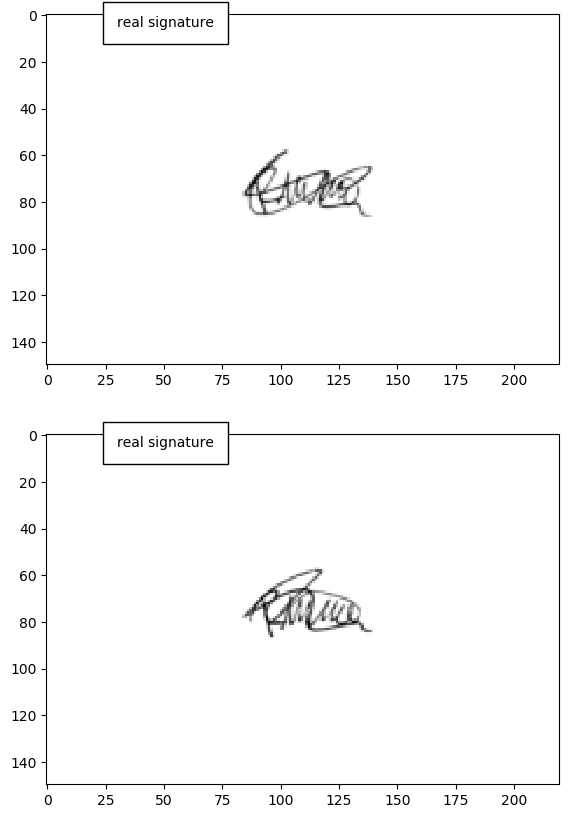

In [41]:
canvas_size = (1000,1400)

_df = train_df[train_df['label']==0].sample(1)
img1 = preprocess_image(load_image(_df['img_path_real'].iloc[0]), canvas_size)
img2 = preprocess_image(load_image(_df['img_path_forged'].iloc[0]), canvas_size)

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary', label='real')
ax1.imshow(img2, cmap='binary')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()

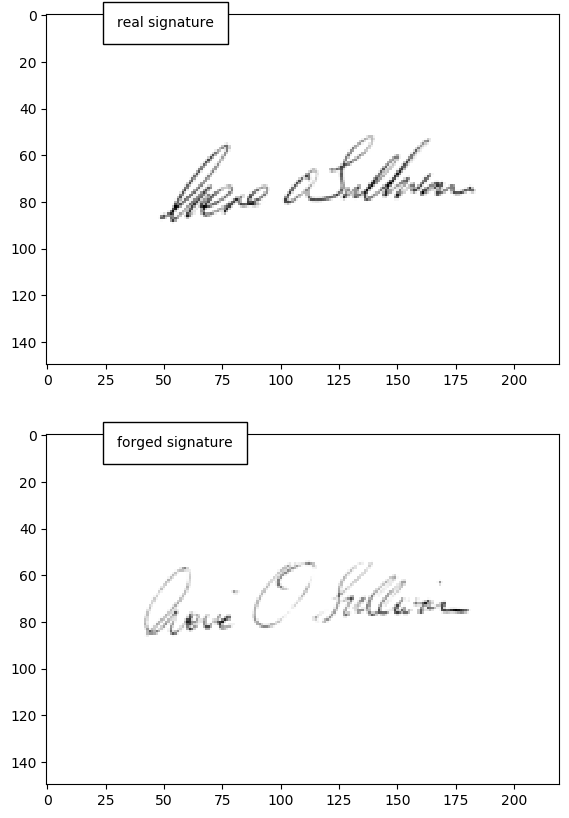

In [43]:
canvas_size = (1000,1400)

_df = train_df[train_df['label']==1].sample(1)
img1 = preprocess_image(load_image(_df['img_path_real'].iloc[0]), canvas_size)
img2 = preprocess_image(load_image(_df['img_path_forged'].iloc[0]), canvas_size)

fig, axs = plt.subplots(2, figsize=(10, 10))
ax0,ax1 = axs
ax0.imshow(img1, cmap='binary', label='real')
ax1.imshow(img2, cmap='binary')
ax0.text(30, 5, 'real signature', bbox={'facecolor': 'white', 'pad': 10})
ax1.text(30, 5, 'forged signature', bbox={'facecolor': 'white', 'pad': 10});
plt.show()